In [1]:
import sys
sys.path.append('/auto/home/filya/3DMolGen')
import os
import numpy as np
import datamol as dm
from rdkit import Chem
import os.path as osp
import ast
from loguru import logger as log
from tqdm import tqdm  
from molgen3D.data_processing.preprocessing_forked_ET_Flow import load_pkl, load_json, embed_coordinates
from molgen3D.evaluation.inference import parse_molecule_with_coordinates
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt


def validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision):
    partitions = ["qm9"]
    rmsds = []
    for partition in partitions:
        # dest_path = osp.join(dest_folder_path, partition.upper())
        # train_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                                 "train_indices.npy"]), allow_pickle=True)))
        # val_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                             "val_indices.npy"]), allow_pickle=True)))
        # log.info(f"{partition} indices contain train:{len(train_indices)}, valid:{len(val_indices)},"\
        #             f" total:{len(train_indices)+len(val_indices)} samples")
        
        mols = load_json(osp.join(raw_path, f"summary_{partition}.json"))
        max_rmsd = 0
        for id, (mol_id, mol_dict) in tqdm(
            enumerate(mols.items()),
            total=len(mols),
            desc=f"Processing molecules of {partition}",
        ):
            if id >= limit:
                break
            mol_pickle = load_pkl(os.path.join(raw_path, mol_dict["pickle_path"]))
            confs = mol_pickle["conformers"]       
            try: 
                for conf in confs:
                    mol, geom_id = conf["rd_mol"], conf["geom_id"]
                    canonical_smiles = dm.to_smiles(
                        mol,
                        canonical=True,
                        explicit_hs=True,
                        with_atom_indices=False,
                        isomeric=False,
                    )
                    atom_order = list(map(int, ast.literal_eval(mol.GetProp('_smilesAtomOutputOrder'))))
                    embedded_smiles = embed_coordinates(mol, canonical_smiles, atom_order, precision)
                    sample = {"canonical_smiles": canonical_smiles,
                                "geom_embed_coordinatesid": geom_id, 
                                "embedded_smiles": embedded_smiles}
                    embedded_smiles = sample["embedded_smiles"]
                    # log.info(embedded_smiles)
                    mol1 = parse_molecule_with_coordinates(embedded_smiles)
                    rmsd = AllChem.GetBestRMS(mol, mol1)
                    rmsds.append(rmsd)
            except Exception as e:
                print(f"Error: {e} for molecule {mol_id}")
    
    rmsds = np.array(rmsds)
    return rmsds

def stat_log(rmsds):
    max_rmsd = np.max(rmsds)
    mean_rmsd = np.mean(rmsds)
    percentile95 = np.percentile(rmsds, 95)
    print(f"Maximum RMSD: {max_rmsd}")
    print(f"Mean RMSD: {mean_rmsd}")
    print(f"95th Percentile: {percentile95}")
    plt.figure(figsize=(8, 6))
    plt.hist(rmsds, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("RMSD")
    plt.ylabel("Frequency")
    plt.title("Distribution of RMSDs")
    plt.show()


/auto/home/filya/miniforge/envs/titan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
dest_folder_path = "geom"
os.makedirs(dest_folder_path, exist_ok=True)

indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "cartesian"
limit = 5000

In [6]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=4)

Processing molecules of qm9:   1%|          | 767/133258 [00:06<10:49, 203.98it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 948/133258 [00:07<09:26, 233.45it/s][18:07:42] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:07:42] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1059/133258 [00:07<06:14, 353.31it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2101/133258 [00:11<02:30, 871.44it/s][18:07:46] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:07:46] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:58<25:08, 85.05it/s]  


Maximum RMSD: 5.9973716512789615e-05
Mean RMSD: 4.717082189365553e-05
95th Percentile: 5.2374369940001826e-05


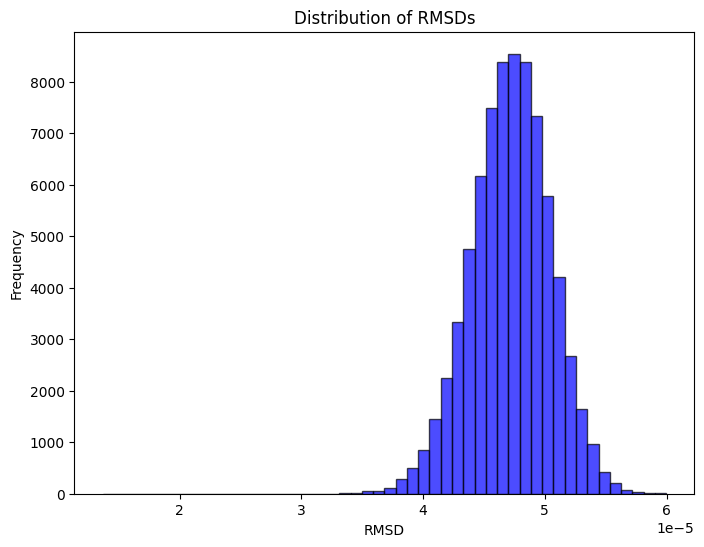

In [7]:
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 753/133258 [00:02<09:22, 235.72it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 1024/133258 [00:03<07:03, 311.88it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2082/133258 [00:08<02:31, 868.67it/s][18:09:30] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:09:30] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:42<18:22, 116.38it/s] 


Maximum RMSD: 0.00059466297736983
Mean RMSD: 0.0004711103543826706
95th Percentile: 0.0005230332800523977


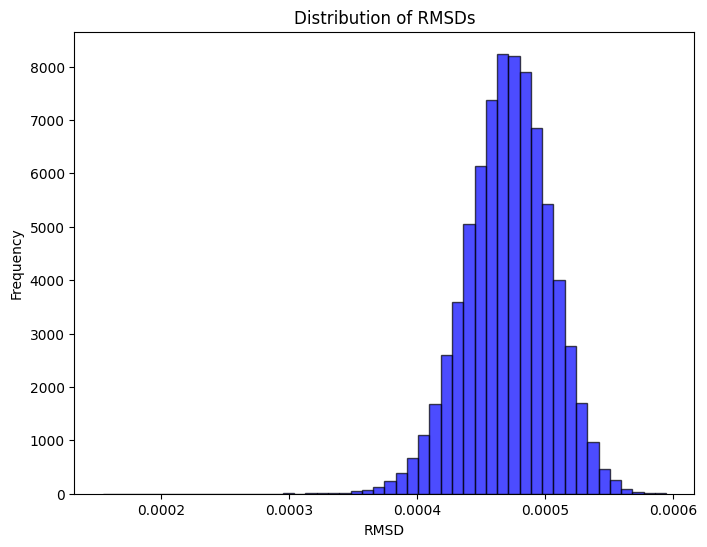

In [8]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=3)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 745/133258 [00:02<09:22, 235.69it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 949/133258 [00:03<09:50, 223.94it/s][18:10:09] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:10:09] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1050/133258 [00:03<07:13, 304.79it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2092/133258 [00:08<02:43, 800.39it/s][18:10:14] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:10:14] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:49<21:09, 100.99it/s] 

Maximum RMSD: 0.006011901342061139
Mean RMSD: 0.004702777946379792
95th Percentile: 0.005228246823179082


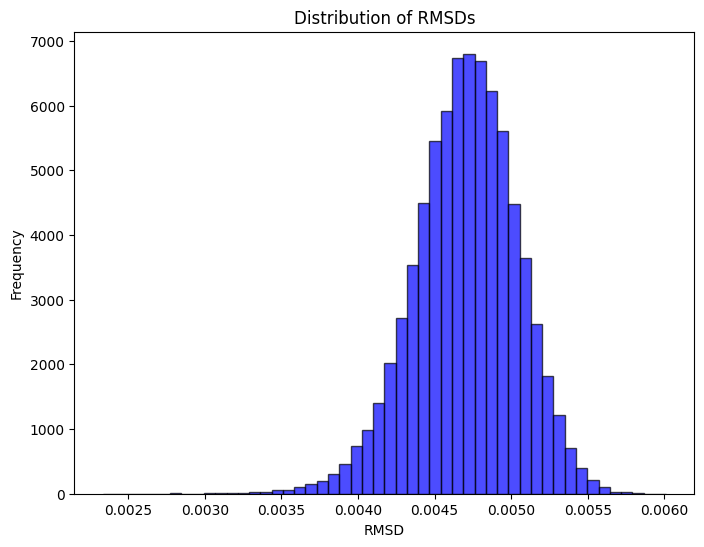

In [9]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=2)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 753/133258 [00:02<09:02, 244.34it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 912/133258 [00:03<11:26, 192.69it/s][18:11:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:11:49] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1029/133258 [00:03<06:24, 343.91it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2082/133258 [00:07<02:28, 884.49it/s][18:11:54] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:11:54] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:37<15:50, 134.89it/s] 

Maximum RMSD: 6.085108419891015e-06
Mean RMSD: 4.716564828831656e-06
95th Percentile: 5.236215178110685e-06


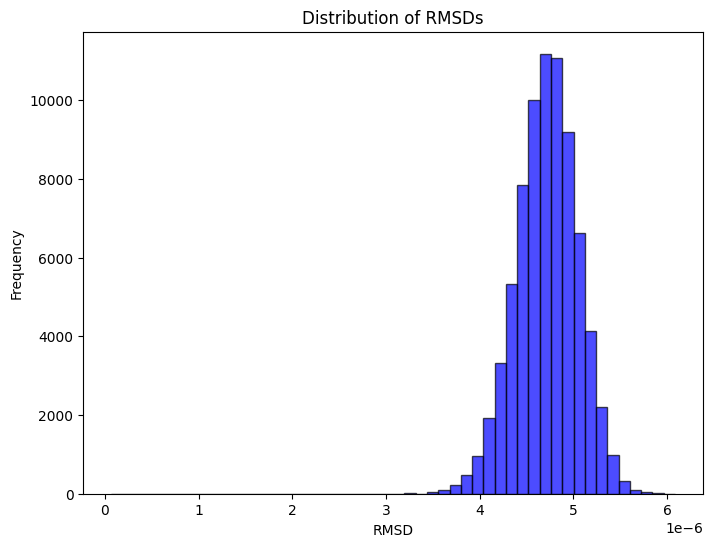

In [10]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=5)
stat_log(rmsds)